In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import math
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
from IPython.display import display, HTML, Javascript, Math, Latex
import datetime
from ipywidgets import widgets, Layout

In [2]:
# from http://blog.nextgenetics.net/?a=2014-m09

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
%%javascript
// functions to find and execute tagged cells
window.findCellTag = function findCellTag(tagName) {
  return (Jupyter.notebook.get_cells()
    .filter(
      ({metadata: {tags}}) => tags && tags.includes(tagName)
    )
    .map((cell) => Jupyter.notebook.find_cell_index(cell))
  );
};

window.reRunCells = function reRunCells() {
    var c = window.findCellTag('rerun');
    Jupyter.notebook.execute_cells(c);
};

<IPython.core.display.Javascript object>

### TO DO

- Make excluding outliers better:
    - set exclusion list to list of outliers, re-run code
- Add error rates to error output?
- Make summary nicer
- Add explanations of calculations
- Look into error rate calculations: check excel sheet? Errors for present only, separate?
- Make sure this gives same results as excel >> test a few
- Handling negative slopes?
- exclusions from demographics
- Descriptions of outputs embedded
- Description of how sheet works/how to use at end/separate notebook
- Label graphs better
- Log transformed histograms
- Add selection for transforming slope ratios: raw, sqrt,log
- Ratio z-test?
- Add date/time stamp to demographics sheet
- Remove unnecessary packages

In [4]:
# import data
long_raw = pd.read_csv('Long Line.csv',
                       names = ["SubjectNumber", "Block", "Trial", "Time", 'Key', 'Exp', 'Error', 'Condition'])
short_raw = pd.read_csv('Short Line.csv',
                        names = ["SubjectNumber", "Block", "Trial", "Time", 'Key', 'Exp', 'Error', 'Condition'])

# set error exclusion threshold (exclude participants with greater error rates)
excl_crit = 0.1

# list participants with error rates above threshold
lrm = long_raw.groupby(by = ['SubjectNumber','Condition']).mean()
long_raw_means = long_raw.groupby(by = ['SubjectNumber','Condition']).mean().groupby(by = ['SubjectNumber']).mean()
short_raw_means = short_raw.groupby(by = ['SubjectNumber','Condition']).mean().groupby(by = ['SubjectNumber']).mean()
long_errors = long_raw_means[long_raw_means['Error'] < (1 - excl_crit)]
short_errors = short_raw_means[short_raw_means['Error'] < (1 - excl_crit)]
exclude_long = long_errors.index.tolist()
exclude_short = short_errors.index.tolist()
error_excl = exclude_long + exclude_short
exclude = []
excl_list = []
for i in error_excl:
    exclude.append((i,'high error'))

## Participants with error rates above threshold
(Excluded from further analysis)

### Long line

In [5]:
if exclude_long == []:
    print('None')
else:
    print(exclude_long)

None


### Short line

In [6]:
if exclude_short == []:
    print('None')
else:
    print(exclude_short)

None


### Threshold

In [7]:
print(str(excl_crit * 100) + '%')

10.0%


In [8]:
def slope(time1, time2, time3):
    """
    returns the slope of the mean response times for 3, 6, and 12 items
    """
    X = [3,6,12]
    y = [time1, time2, time3]
    X = sm.add_constant(X) ## adds intercept to regression model
    
    model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
    predictions = model.predict(X)

    return model.params[1]

# update exclusion list
for i in exclude:
    excl_list.append(i[0])

# read raw data
long_data = pd.read_csv('Long Line.csv',
                        names = ["SubjectNumber", "Block", "Trial", "Time", 'Key', 'Exp', 'Error', 'Condition'])
short_data = pd.read_csv('Short Line.csv',
                         names = ["SubjectNumber", "Block", "Trial", "Time", 'Key', 'Exp', 'Error', 'Condition'])

# exclude error trials
long_data = long_data[long_data['Error'] == 1]
short_data = short_data[short_data['Error'] == 1]

# exclude participants with error rate above exclusion threshold
long_data = long_data[~long_data['SubjectNumber'].isin(excl_list)]
short_data = short_data[~short_data['SubjectNumber'].isin(excl_list)]

# log transform Time
long_data['Time'] = long_data['Time'].apply(math.log10)
short_data['Time'] = short_data['Time'].apply(math.log10)

# create a table of mean response time in each condition (target type x item number)
# PRESENT trials
long3 = long_data[(long_data['Condition'] == 1) & (long_data['Exp'] == 1)].groupby(by = ['SubjectNumber']).mean()
long6 = long_data[(long_data['Condition'] == 2) & (long_data['Exp'] == 1)].groupby(by = ['SubjectNumber']).mean()
long12 = long_data[(long_data['Condition'] == 3) & (long_data['Exp'] == 1)].groupby(by = ['SubjectNumber']).mean()
short3 = short_data[(short_data['Condition'] == 1) & (short_data['Exp'] == 1)].groupby(by = ['SubjectNumber']).mean()
short6 = short_data[(short_data['Condition'] == 2) & (short_data['Exp'] == 1)].groupby(by = ['SubjectNumber']).mean()
short12 = short_data[(short_data['Condition'] == 3) & (short_data['Exp'] == 1)].groupby(by = ['SubjectNumber']).mean()

# ABSENT trials
a_long3 = long_data[(long_data['Condition'] == 1) & (long_data['Exp'] == 0)].groupby(by = ['SubjectNumber']).mean()
a_long6 = long_data[(long_data['Condition'] == 2) & (long_data['Exp'] == 0)].groupby(by = ['SubjectNumber']).mean()
a_long12 = long_data[(long_data['Condition'] == 3) & (long_data['Exp'] == 0)].groupby(by = ['SubjectNumber']).mean()
a_short3 = short_data[(short_data['Condition'] == 1) & (short_data['Exp'] == 0)].groupby(by = ['SubjectNumber']).mean()
a_short6 = short_data[(short_data['Condition'] == 2) & (short_data['Exp'] == 0)].groupby(by = ['SubjectNumber']).mean()
a_short12 = short_data[(short_data['Condition'] == 3) & (short_data['Exp'] == 0)].groupby(by = ['SubjectNumber']).mean()

# assemble lists into dataframe
present_data_log = pd.DataFrame({'long3':long3['Time'], 'long6':long6['Time'], 'long12':long12['Time'],
                             'short3':short3['Time'], 'short6':short6['Time'], 'short12':short12['Time']})

absent_data_log = pd.DataFrame({'long3':a_long3['Time'], 'long6':a_long6['Time'], 'long12':a_long12['Time'],
                             'short3':a_short3['Time'], 'short6':a_short6['Time'], 'short12':a_short12['Time']})

# backtransform log times
present_data = 10**present_data_log
absent_data = 10**absent_data_log

In [9]:
# add columns for slopes and slope ratio
present_data['long_slope'] = slope(present_data['long3'], present_data['long6'], present_data['long12'])
present_data['short_slope'] = slope(present_data['short3'], present_data['short6'], present_data['short12'])
present_data['slope_ratio'] = present_data['short_slope']/present_data['long_slope']
present_data['slope_ratio_sqrt'] = np.sqrt(present_data['slope_ratio'])

absent_data['long_slope'] = slope(absent_data['long3'], absent_data['long6'], absent_data['long12'])
absent_data['short_slope'] = slope(absent_data['short3'], absent_data['short6'], absent_data['short12'])
absent_data['slope_ratio'] = absent_data['short_slope']/absent_data['long_slope']
absent_data['slope_ratio_sqrt'] = np.sqrt(absent_data['slope_ratio'])

# add baselines
present_data['long_base'] = present_data['long12'] - present_data['long_slope'] * 11
present_data['short_base'] = present_data['short12'] - present_data['short_slope'] * 11
absent_data['long_base'] = present_data['long12'] - present_data['long_slope'] * 11
absent_data['short_base'] = present_data['short12'] - present_data['short_slope'] * 11

## Present data

In [10]:
present_data.round(3)

,long3,long6,long12,short3,short6,short12,long_slope,short_slope,slope_ratio,slope_ratio_sqrt,long_base,short_base
SubjectNumber,,,,,,,,,,,,
1,1176.035,1199.415,1714.006,996.065,1177.953,1527.367,63.488,58.920,0.928,0.963,1015.643,879.252
2,825.426,1079.001,1577.299,852.681,1082.481,1315.243,83.471,49.595,0.594,0.771,659.116,769.693
3,842.587,1148.614,1357.055,1156.636,1258.601,1580.630,53.960,48.048,0.890,0.944,763.496,1052.105
4,988.143,1087.885,1511.089,1428.006,1939.638,2694.628,59.881,138.607,2.315,1.521,852.402,1169.955
5,799.526,871.306,1084.953,856.567,1080.385,1234.860,32.270,39.706,1.230,1.109,729.979,798.096
6,1023.676,1264.810,1604.251,1152.908,1309.130,1584.798,63.375,47.696,0.753,0.868,907.129,1060.143
7,802.786,1002.408,1006.958,772.026,884.458,1068.610,19.553,32.631,1.669,1.292,791.872,709.672
8,778.892,811.243,969.148,859.173,964.549,1445.245,21.879,67.262,3.074,1.753,728.476,705.368
9,1472.881,2432.998,2371.151,1265.661,1321.390,1570.674,84.077,34.984,0.416,0.645,1446.304,1185.848


#### Summary statistics

In [11]:
present_desc = present_data.describe()
present_desc.round(3)

,long3,long6,long12,short3,short6,short12,long_slope,short_slope,slope_ratio,slope_ratio_sqrt,long_base,short_base
count,24.000,24.000,24.000,24.000,24.000,24.000,24.000,24.000,24.000,24.000,24.000,24.000
mean,986.622,1189.153,1439.155,1086.884,1231.492,1619.925,49.051,60.014,1.474,1.167,899.596,959.769
std,235.874,362.882,391.377,243.155,304.608,447.407,22.860,29.834,0.906,0.341,229.209,215.473
min,671.209,798.001,935.557,772.026,821.774,1068.610,16.966,32.631,0.416,0.645,583.931,678.996
25%,809.255,993.552,1103.380,856.841,1067.597,1345.399,29.974,40.818,0.880,0.938,737.823,756.155
50%,880.362,1086.151,1430.705,1048.219,1210.021,1575.652,44.352,48.934,1.221,1.105,823.388,978.846
75%,1183.629,1272.253,1663.823,1277.263,1323.286,1735.845,64.626,66.686,1.673,1.293,1012.802,1171.413
max,1472.881,2432.998,2371.151,1670.923,2078.336,2990.811,86.775,147.429,3.863,1.966,1446.304,1369.090


#### t-test

In [12]:
present_t = stats.ttest_rel(present_data['short_slope'],present_data['long_slope'])
base_t = stats.ttest_rel(present_data['short_base'],present_data['long_base'])

present_t

Ttest_relResult(statistic=1.5563030448960287, pvalue=0.13329025391649255)

### Summary:

In [13]:
l_slope_mean = present_desc['long_slope']['mean']
s_slope_mean = present_desc['short_slope']['mean']
l_slope_sd = present_desc['long_slope']['std']
s_slope_sd = present_desc['short_slope']['std']
l_base_mean = present_desc['long_base']['mean']
s_base_mean = present_desc['short_base']['mean']
l_base_sd = present_desc['long_base']['std']
s_base_sd = present_desc['short_base']['std']

slope_p_val = present_t[1]
slope_t_stat = present_t[0]
base_p_val = base_t[1]
base_t_stat = base_t[0]
slope_ratio = present_desc['slope_ratio']['mean']
ratio_sqrt = present_desc['slope_ratio_sqrt']['mean']
ratio_log = 'nothing yet'
# ratio_log = present_desc['slope_ratio_log']['mean']

summary_table = pd.DataFrame(columns=['slope_mean','slope_sd','baseline_mean','baseline_sd'],
                             index=['long','short','t-stat','p-value'])

summary_table.loc['long'] = pd.Series({'slope_mean':round(l_slope_mean,3),
                                       'slope_sd':round(l_slope_sd,3),
                                       'baseline_mean':round(l_base_mean,3),
                                       'baseline_sd':round(l_base_sd,3)})

summary_table.loc['short'] = pd.Series({'slope_mean':round(present_desc['short_slope']['mean'],3),
                                        'slope_sd':round(present_desc['short_slope']['std'],3),
                                        'baseline_mean':round(present_desc['short_base']['mean'],3),
                                        'baseline_sd':round(present_desc['short_base']['std'],3)})

summary_table.loc['t-stat'] = pd.Series({'slope_mean':round(slope_t_stat,3),
                                         'slope_sd':'',
                                         'baseline_mean':round(base_t_stat,3),
                                         'baseline_sd':''})

summary_table.loc['p-value'] = pd.Series({'slope_mean':round(slope_p_val,5),
                                          'slope_sd':'',
                                          'baseline_mean':round(base_p_val,5),
                                          'baseline_sd':''})

display(summary_table)


print('\nSlope ratio: ' + str(round(slope_ratio,3)))
print('Slope ratio (square root): ' + str(round(ratio_sqrt,3)))
print('Slope ratio (log): ' + str(ratio_log))
print("\nParticipants excluded:")
if len(exclude) == 0:
    print('None')
else:
    for i in exclude:
        print('Number ' + str(i[0]) + ' for ' + str(i[1]))

,slope_mean,slope_sd,baseline_mean,baseline_sd
long,49.051,22.86,899.596,229.209
short,60.014,29.834,959.769,215.473
t-stat,1.556,,1.528,
p-value,0.13329,,0.14008,



Slope ratio: 1.474
Slope ratio (square root): 1.167
Slope ratio (log): nothing yet

Participants excluded:
None


## Absent data

In [14]:
absent_data.round(3)

,long3,long6,long12,short3,short6,short12,long_slope,short_slope,slope_ratio,slope_ratio_sqrt,long_base,short_base
SubjectNumber,,,,,,,,,,,,
1,2455.576,2602.798,3662.264,1379.790,1587.588,2159.286,140.148,87.850,0.627,0.792,1015.643,879.252
2,1028.876,1412.344,2172.344,1403.716,1827.921,2721.271,126.997,146.752,1.156,1.075,659.116,769.693
3,1026.064,1433.724,1686.656,1181.739,1622.874,1852.888,68.936,69.396,1.007,1.003,763.496,1052.105
4,853.233,1226.878,1558.408,1410.977,1976.286,2825.042,75.053,154.881,2.064,1.437,852.402,1169.955
5,944.831,1221.402,1537.417,1148.310,1203.585,1954.831,63.961,94.698,1.481,1.217,729.979,798.096
6,1179.023,1710.312,2055.634,1796.354,2335.281,2957.397,91.709,125.388,1.367,1.169,907.129,1060.143
7,981.047,1225.501,1504.560,1083.841,1624.197,2193.138,56.503,119.193,2.110,1.452,791.872,709.672
8,914.580,1236.270,1483.590,1257.862,1821.723,2526.740,60.080,137.632,2.291,1.514,728.476,705.368
9,2266.424,3151.429,3947.551,1350.419,1611.272,2360.524,179.063,114.040,0.637,0.798,1446.304,1185.848


#### Summary statistics

In [15]:
absent_desc = absent_data.describe()
absent_desc.round(3)

,long3,long6,long12,short3,short6,short12,long_slope,short_slope,slope_ratio,slope_ratio_sqrt,long_base,short_base
count,24.000,24.000,24.000,24.000,24.000,24.000,24.000,24.000,24.000,24.000,24.000,24.000
mean,1267.022,1668.764,2087.449,1336.243,1723.290,2384.206,88.105,115.542,1.892,1.253,899.596,959.769
std,425.843,563.899,729.123,250.240,269.748,431.098,42.559,40.592,2.647,0.579,229.209,215.473
min,820.233,930.195,1117.934,963.268,1203.585,1282.712,12.273,30.500,0.627,0.792,583.931,678.996
25%,1003.754,1226.534,1541.803,1144.450,1595.108,2147.559,59.186,85.516,0.972,0.986,737.823,756.155
50%,1121.220,1500.840,2011.162,1359.373,1725.363,2435.227,84.156,116.959,1.230,1.109,823.388,978.846
75%,1404.527,1880.476,2494.332,1432.455,1871.263,2691.806,125.288,148.304,1.886,1.373,1012.802,1171.413
max,2455.576,3151.429,3947.551,1894.815,2335.281,3056.502,179.063,179.992,14.051,3.748,1446.304,1369.090


#### t-test

In [16]:
stats.ttest_rel(absent_data['short_slope'],absent_data['long_slope'])

Ttest_relResult(statistic=2.773464120272972, pvalue=0.010808323392464231)

In [17]:
def draw_histogram(col):
    present_data[col].plot.hist()
    plt.axvline(present_desc[col]['mean'] - present_desc[col]['std'] * 2, color='r')
    plt.axvline(present_desc[col]['mean'] + present_desc[col]['std'] * 2, color='r')

def draw_density(col):
    present_data[col].plot.kde(bw_method=0.2)
    plt.axvline(present_desc[col]['mean'] - present_desc[col]['std'] * 2, color='r')
    plt.axvline(present_desc[col]['mean'] + present_desc[col]['std'] * 2, color='r')

In [18]:
widgets.interact(draw_histogram, col=['long_slope','short_slope','slope_ratio','slope_ratio_sqrt'])

interactive(children=(Dropdown(description='col', options=('long_slope', 'short_slope', 'slope_ratio', 'slope_…

<function __main__.draw_histogram(col)>

In [19]:
widgets.interact(draw_density, col=['long_slope','short_slope','slope_ratio','slope_ratio_sqrt'])

interactive(children=(Dropdown(description='col', options=('long_slope', 'short_slope', 'slope_ratio', 'slope_…

<function __main__.draw_density(col)>

## Outlier tests

In [20]:
out_crit = 2

In [21]:
# list participants with a slope/ratio over 2 sd from the mean
high_long = present_data[present_data['long_slope'] > 
                         present_desc['long_slope']['mean'] + present_desc['long_slope']['std'] * out_crit]
high_short = present_data[present_data['short_slope'] > 
                          present_desc['short_slope']['mean'] + present_desc['short_slope']['std'] * out_crit]
high_ratio = present_data[present_data['slope_ratio_sqrt'] > 
                          present_desc['slope_ratio_sqrt']['mean'] + present_desc['slope_ratio_sqrt']['std'] * out_crit]

low_long = present_data[present_data['long_slope'] < 
                         present_desc['long_slope']['mean'] - present_desc['long_slope']['std'] * out_crit]
low_short = present_data[present_data['short_slope'] < 
                          present_desc['short_slope']['mean'] - present_desc['short_slope']['std'] * out_crit]
low_ratio = present_data[present_data['slope_ratio_sqrt'] < 
                          (present_desc['slope_ratio_sqrt']['mean'] - present_desc['slope_ratio_sqrt']['std'] * out_crit)]

#### High long slope

In [22]:
if high_long.index.tolist() == []:
    print('None')
else:
    for i in high_long.index.tolist():
        x = (present_data['long_slope'][i] - present_desc['long_slope']['mean'])/present_desc['long_slope']['std']
        print('Subject ' + str(i) + '  z-score: ' + str(round(x,3)))
        exclude.append((i,'high long slope'))

None


#### Low long slope

In [23]:
if low_long.index.tolist() == []:
    print('None')
else:
    for i in low_long.index.tolist():
        x = (present_data['long_slope'][i] - present_desc['long_slope']['mean'])/present_desc['long_slope']['std']
        print('Subject ' + str(i) + '  z-score: ' + str(round(x,3)))
        exclude.append((i,'low long slope'))

None


#### High short slope

In [24]:
if high_short.index.tolist() == []:
    print('None')
else:
    for i in high_short.index.tolist():
        x = (present_data['short_slope'][i] - present_desc['short_slope']['mean'])/present_desc['short_slope']['std']
        print('Subject ' + str(i) + '  z-score: ' + str(round(x,3)))
        exclude.append((i,'high short slope'))

Subject 4  z-score: 2.634
Subject 16  z-score: 2.93


#### Low short slope

In [25]:
if low_short.index.tolist() == []:
    print('None')
else:
    for i in low_short.index.tolist():
        x = (present_data['short_slope'][i] - present_desc['short_slope']['mean'])/present_desc['short_slope']['std']
        print('Subject ' + str(i) + '  z-score: ' + str(round(x,3)))
        exclude.append((i,'low short slope'))

None


#### High slope ratio

In [26]:
if high_ratio.index.tolist() == []:
    print('None')
else:
    for i in high_ratio.index.tolist():
        x = ((present_data['slope_ratio_sqrt'][i] - present_desc['slope_ratio_sqrt']['mean'])
             /present_desc['slope_ratio_sqrt']['std'])
        print('Subject ' + str(i) + '  z-score: ' + str(round(x,3)))
        exclude.append((i,'high slope ratio'))

Subject 13  z-score: 2.099
Subject 16  z-score: 2.341


#### Low slope ratio

In [27]:
if low_ratio.index.tolist() == []:
    print('None')
else:
    for i in low_ratio.index.tolist():
        x = ((present_data['slope_ratio_sqrt'][i] - present_desc['slope_ratio_sqrt']['mean'])
             /present_desc['slope_ratio_sqrt']['std'])
        print('Subject ' + str(i) + '  z-score: ' + str(round(x,3)))
        exclude.append((i,'low slope ratio'))

None


### Outliers:

In [51]:
# remove duplicates and sort exclusions
exclude = list(dict.fromkeys(exclude))
exclude.sort()
exclude_text = ''
for i in exclude:
    exclude_text = exclude_text + '\n' + 'Number ' + str(i[0]) + ' for ' + str(i[1])
print(exclude_text)


Number 4 for high short slope
Number 13 for high slope ratio
Number 16 for high short slope
Number 16 for high slope ratio


### Re-run analysis with outliers removed:

In [29]:
def re_run(x):
    """
    sets exclude to the full list of outliers, then re-runs cells tagged with 'rerun'
    (View > Cell Toolbar > Tags to show/edit tags)
    """
    display(Javascript("window.reRunCells()"))

butt = widgets.Button(button_style='success', description='Re-run')
butt.on_click(re_run)
display(butt)

Button(button_style='success', description='Re-run', style=ButtonStyle())

## Demographic data

In [30]:
demo_filename='50NS(T2).LinkingOnlyDemographicsTest.csv'

In [31]:
# import data
col_list = list(range(0,37))
demo_data = pd.read_csv(demo_filename, header=1, index_col='SubjectNumber', usecols=col_list, nrows=16)
demo_data

,Qs,Subject ID,Ethnicity,Condition,Gender,Handedness,Eyewear,Age,Time,YearsInCanada,...,%4,2ndMostCompetentLanguage_ThroughoutLife,%5,3rdMostCompetentLanguage_ThroughoutLife,%6,first_aquired_written_language,first_aquired_reading_language,first_aquired_speaking_language,stress,stress_reason
SubjectNumber,,,,,,,,,,,,,,,,,,,,,
1,01Q,01JF,CAUCASIAN,50NST2,Female,Right,None,19,0,19.00,...,98,FRENCH,2,0,0.00,ENGLISH,ENGLISH,ENGLISH,3.0,3 FROM SCHOOL WORK
2,02Q,02MK,Turkish,50ND(T2),Female,Right,None,27,4PM,0.10,...,90,English,10,0,0.00,Turkish,Turkish,Turkish,2.0,2
3,03Q,03TY,Chinese,42NST2,Female,Right,Contacts,24,0,23.00,...,70,Cantonese,25,Mandarin,2.00,English,English,Cantonese,6.0,6 - school
4,04Q,04AY,Arab,49.T2,Female,Right,None,22,0.625,0.50,...,55,Arabic,45,0,0.00,English,English,English,0.0,0
5,05Q,05EL,Asian,50NS(T2),Female,Right,None,21,0,4.00,...,45,Mandarin,45,English,10.00,Mandarin,Mandarin,Cantonese,4.0,stress level: 4
6,06Q,06AM,South and Southeast Asian,50NST2,Female,Right,None,19,3PM,2.00,...,80,Spanish,15,Mandarin,5.00,English,English,English,4.0,4- anxiety about medication and upcoming midterm
7,07Q,07CL,Asian,50NS(T2),Female,Right,None,18,2PM,1.00,...,70,English,30,0,0.00,Cantonese,Cantonese,Cantonese,5.0,5 (school & others)
8,08Q,08AH,German,50NS(T2).LikingOnly,Female,Left,None,24,11:00am,0.25,...,80,English,15,Spanish,3.00,German,German,German,3.0,3 - personal
9,09Q,01AP,South east asian,50 T2,Female,Right,None,20,0.5,20.00,...,100,0,0,0,0.00,English,English,English,0.0,0


### Slope ratio and years in Canada correlation

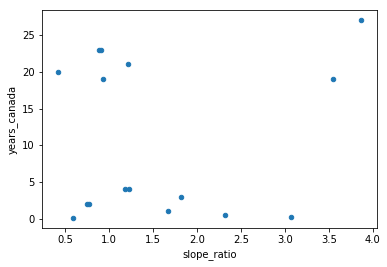

In [32]:
corr_frame = pd.DataFrame({'slope_ratio':present_data['slope_ratio'],
                           'stress':demo_data['stress'],
                           'years_canada':demo_data['YearsInCanada'],
                           'perc_in_can':demo_data['Calculated_PercIN']})

corr_frame.plot.scatter('slope_ratio','years_canada')

In [33]:
if len(present_data['slope_ratio']) == len(demo_data['YearsInCanada']):
    corr_out = stats.pearsonr(present_data['slope_ratio'],demo_data['YearsInCanada'])
    print("Pearson's r: " + str(corr_out[0]) + '   p-value: ' + str(corr_out[1]))
else:
    print('Demographic data does not match VS data')

Demographic data does not match VS data


In [34]:
if len(present_data['slope_ratio']) == len(demo_data['Calculated_PercIN']):
    corr_out = stats.pearsonr(present_data['slope_ratio'],demo_data['Calculated_PercIN'])
    print("Pearson's r: " + str(corr_out[0]) + '   p-value: ' + str(corr_out[1]))
else:
    print('Demographic data does not match VS data')

Demographic data does not match VS data


### Slope ratio and stress correlation

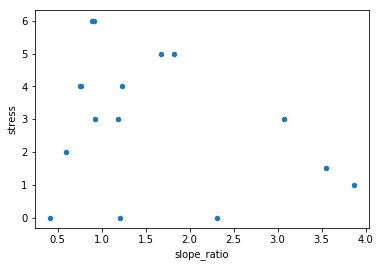

In [35]:
corr_frame.plot.scatter('slope_ratio','stress')

In [36]:
if len(present_data['slope_ratio']) == len(demo_data['stress']):
    corr_out = stats.pearsonr(present_data['slope_ratio'],demo_data['stress'])
    print("Pearson's r: " + str(corr_out[0]) + '   p-value: ' + str(corr_out[1]))
else:
    print('Demographic data does not match VS data')

Demographic data does not match VS data


### Comparison of participants living in Canada less/more than 2 years

In [37]:
if len(corr_frame['slope_ratio']) == len(corr_frame['years_canada']):
    stats.ttest_ind(corr_frame[corr_frame['years_canada'] < 2]['slope_ratio'],
                    corr_frame[corr_frame['years_canada'] >= 2]['slope_ratio'])
else:
    print('Demographic data does not match VS data')

##  Graphs

In [38]:
grouped = long_data.groupby(['SubjectNumber', 'Condition'])
grouped.mean()

Block      Trial      Time       Key       Exp  \
SubjectNumber Condition                                                      
1             1          3.040816  15.000000  3.227024  0.510204  0.510204   
              2          3.000000  15.320000  3.247205  0.500000  0.500000   
              3          2.956522  16.000000  3.413217  0.456522  0.456522   
2             1          3.000000  14.140000  2.964521  0.500000  0.500000   
              2          3.040816  15.224490  3.092674  0.489796  0.489796   
              3          3.086957  17.521739  3.273465  0.456522  0.456522   
3             1          3.000000  13.820000  2.968395  0.500000  0.500000   
              2          3.041667  16.354167  3.110326  0.479167  0.479167   
              3          3.063830  16.127660  3.182826  0.468085  0.468085   
4             1          3.000000  15.440000  2.962944  0.500000  0.500000   
              2          3.020833  14.791667  3.063780  0.479167  0.479167   
              3          2.958333  16.354167  3.186265  0.479167  0.479167   
5             1          3.000000  15.000000  2.939094  0.500000  0.500000   
              2          3.000000  15.734694  3.015011  0.489796  0.489796   
              3          2.959184  15.897959  3.109557  0.510204  0.510204   
6             1          3.083333  15.083333  3.042121  0.479167  0.479167   
              2          3.020833  15.708333  3.170281  0.479167  0.479167   
              3          2.959184  15.571429  3.260208  0.489796  0.489796   
7             1          3.000000  13.480000  2.948145  0.500000  0.500000   
              2          3.020833  16.875000  3.044679  0.500000  0.500000   
              3          3.021739  16.586957  3.094002  0.478261  0.478261   
8             1          3.000000  16.480000  2.926349  0.500000  0.500000   
              2          3.040816  16.183673  3.002499  0.489796  0.489796   
              3          3.041667  14.250000  3.082705  0.479167  0.479167   
9             1          3.000000  15.958333  3.257855  0.520833  0.520833   
              2          3.083333  14.166667  3.444666  0.479167  0.479167   
              3          2.959184  16.244898  3.487902  0.489796  0.489796   
10            1          3.040816  14.102041  3.147851  0.510204  0.510204   
              2          2.979167  16.000000  3.232070  0.479167  0.479167   
              3          2.909091  17.204545  3.296629  0.431818  0.431818   
...                           ...        ...       ...       ...       ...   
15            1          2.979592  14.469388  3.176514  0.489796  0.489796   
              2          3.020408  14.612245  3.242685  0.489796  0.489796   
              3          2.979167  17.791667  3.359273  0.479167  0.479167   
16            1          3.000000  15.060000  3.080939  0.500000  0.500000   
              2          3.000000  15.440000  3.186760  0.500000  0.500000   
              3          3.020408  16.102041  3.262263  0.510204  0.510204   
17            1          3.000000  14.820000  2.981551  0.500000  0.500000   
              2          3.000000  14.340000  3.135215  0.500000  0.500000   
              3          3.000000  17.270833  3.279619  0.479167  0.479167   
18            1          3.000000  15.285714  2.976132  0.489796  0.489796   
              2          3.000000  15.680000  3.052394  0.500000  0.500000   
              3          2.977778  14.622222  3.124750  0.444444  0.444444   
19            1          3.000000  16.420000  2.879312  0.500000  0.500000   
              2          3.040816  15.000000  2.935968  0.489796  0.489796   
              3          3.062500  15.166667  3.009743  0.500000  0.500000   
20            1          3.000000  16.240000  3.140340  0.500000  0.500000   
              2          3.000000  15.640000  3.313605  0.500000  0.500000   
              3          2.978261  15.021739  3.380329  0.456522  0.456522   
21            1          3.000000  15.740000  3.07

([<matplotlib.axis.XTick at 0x1e76ec6b208>,
 <a list of 4 Text xticklabel objects>)

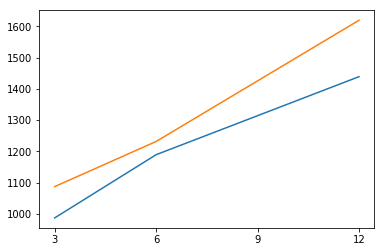

In [39]:
# plot a line for long and short targets over item numbers in present trials
plt.plot([3,6,12], [present_desc.iat[1,0],present_desc.iat[1,1],present_desc.iat[1,2]])
plt.plot([3,6,12], [present_desc.iat[1,3],present_desc.iat[1,4],present_desc.iat[1,5]])
plt.xticks([3,6,9,12])

([<matplotlib.axis.XTick at 0x1e76ecfe0b8>,
 <a list of 4 Text xticklabel objects>)

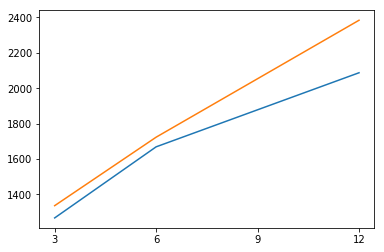

In [40]:
# plot a line for long and short targets over item numbers in absent trials
plt.plot([3,6,12], [absent_desc.iat[1,0],absent_desc.iat[1,1],absent_desc.iat[1,2]])
plt.plot([3,6,12], [absent_desc.iat[1,3],absent_desc.iat[1,4],absent_desc.iat[1,5]])
plt.xticks([3,6,9,12])

C:\Users\Mike\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Mike\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


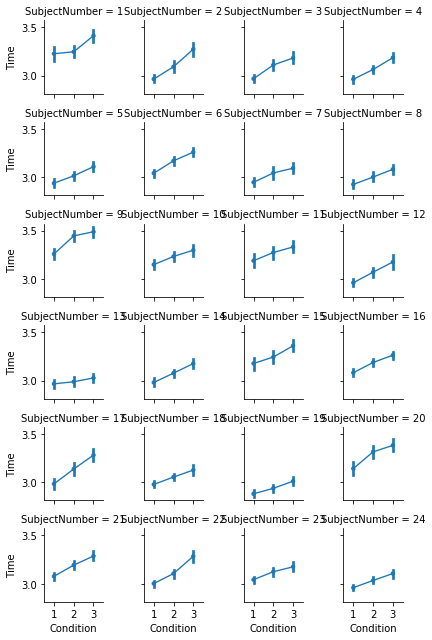

In [41]:
g = sns.FacetGrid(long_data, col="SubjectNumber", col_wrap=4, height=1.5)
g = g.map(sns.pointplot, "Condition", "Time", marker=".", scale=0.5)

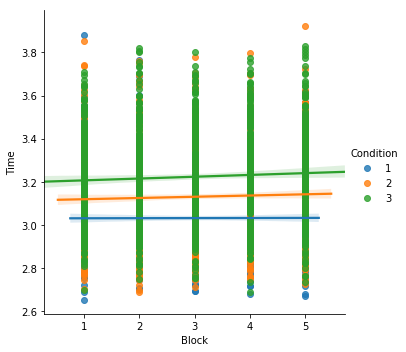

In [42]:
sns.lmplot("Block", "Time", data=long_data, hue="Condition", 
           fit_reg=True)

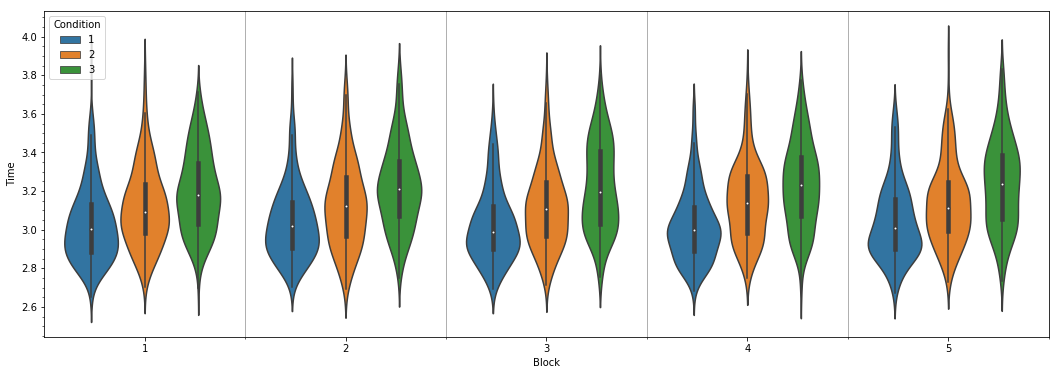

In [43]:
# From https://towardsdatascience.com/a-guide-to-pandas-and-matplotlib-for-data-exploration-56fad95f951c

from matplotlib.ticker import AutoMinorLocator

fig = plt.figure(figsize=(18,6))

ax1 = sns.violinplot('Block', "Time", 
                     data=long_data, hue='Condition')

ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.grid(which='minor', axis='x', linewidth=1)

### Formulas etc.

Visual search basics?

Target:

Distractor:

Set size: 

Symmetry?:

Slope: slope of the regression line of mean time of trials of each set size over the set sizes. Estimates the increase in response time per addition of one item to the display.

Slope ratio: the ratio of the slope of short target trials over the slope for long target trials. (short slope) / (long slope)

Baseline: the estimated time it would take the participant to respond in a trial with set size of one. Calculated here for each the long target and short target trials as (mean response time for set size of 12) - (slope) x 11

In [45]:
print ("Condition name:")
name_box = widgets.Textarea(layout=Layout(width='900px', height='50px'))
display(name_box)

print("Condition description:")
des_box = widgets.Textarea(layout=Layout(width='900px', height='100px'))
display(des_box)

print("Condition purpose or goal:")
purpose_box = widgets.Textarea(layout=Layout(width='900px', height='100px'))
display(purpose_box)

print("Object Recognition Task description:")
or_box = widgets.Textarea(layout=Layout(width='900px', height='100px'))
display(or_box)

print("Visual Search Task description:")
vs_box = widgets.Textarea(layout=Layout(width='900px', height='100px'))
display(vs_box)

print('Analysis Notes & Comments')
text = widgets.Textarea(layout=Layout(width='900px', height='100px'))
display(text)

Condition name:


Textarea(value='', layout=Layout(height='50px', width='900px'))

Condition description:


Textarea(value='', layout=Layout(height='100px', width='900px'))

Condition purpose or goal:


Textarea(value='', layout=Layout(height='100px', width='900px'))

Object Recognition Task description:


Textarea(value='', layout=Layout(height='100px', width='900px'))

Visual Search Task description:


Textarea(value='', layout=Layout(height='100px', width='900px'))

Analysis Notes & Comments


Textarea(value='', layout=Layout(height='100px', width='900px'))

In [46]:
# button to create receipt
button = widgets.Button(description="Create analysis receipt",
                       layout=Layout(width='200px', height='30px'))
display(button)

# functio to gather's analysis summary info and returning a list of strings to be printed
# assigns appropriate values to global analysis summary values
def gather():
    name=name_box.value
    description=des_box.value
    purpose=purpose_box.value
    or_task=or_box.value
    vs_task=vs_box.value
    comments=text.value
    
    return["Condition name: "+name,
          "\nCondition description: "+ description,
          "\nCondition purpose or goal: "+purpose,
          "\nObject Recognition task description: "+ or_task,
          "\nVisual Search task description: "+ vs_task,
          #"\nAnalysis " +str(datetime.datetime.now()[:10]),
          "\nLong slope:",
          "  Mean: "+str(round(l_slope_mean,2)),
          "  SD: "+str(round(l_slope_sd,2)),
          "\nShort slope:",
          "  Mean: "+str(round(s_slope_mean,2)),
          "  SD: "+str(round(s_slope_sd,2)),
          "\np-value: "+str(round(slope_p_val,5)),
          "\nt-stat: "+str(round(slope_t_stat,2)),
          "\nSlope ratio: "+str(round(slope_ratio,2)),
          "\nSlope ratio (square root): "+str(round(ratio_sqrt,2)),
          "\nExcluded participants: " + exclude_text,
          "\nAnalysis notes & comments: "+ comments]


    

# function to handle button click event
# should get all the values that were inputted above that are gonig to be printed on the abalysis receipt
def receipt_button_clicked(b):
    content=gather()
    r=open("AnalysisReceipt.txt","w+")
    for i in content:
        r.write("\n")
        r.write(i)
    #write_file()
    #print_file()
    
    print("File created")
    


button.on_click(receipt_button_clicked)

global comments
comments=text.value



Button(description='Create analysis receipt', layout=Layout(height='30px', width='200px'), style=ButtonStyle()…